# Clustering tweets

The data is collected and prepared (to the best of my ability). Now it is time to cluster it! This is based on a [simple recipe](https://nlpforhackers.io/recipe-text-clustering/). Before moving to actual code, it is important to know what is underlying.

## TF-IDF terms

Machine learning models understand only one thing: numbers. There are many possible conversions: bag-of-words; one-hot encoding... But for the purposes of clustering, [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is the chosen approach here. It stands for **term frequency-inverse document frequency** (tf-idf) and it is composed by two components.

### term frequency (tf)

- term frequency is the number of times a term occurs in a document (or tweet).
- given that documents have different lengths, the term frequency is weighted.
- keep in mind, this is a measure for each tweet, or row in the dataset; not an aggregation.

According to the wikipedia link above, one could define term-frequency according to one of four measures. For the sake of example, let us go over _augmented frequency_. Let $f_{t,d}$ denote frequency of term $t$ in document $d$, or raw count. To prevent bias towards longer documents, an augmented frequency $t(f,d)$ measure divides raw frequency of term by that of the maximum frequency found in $d$ and weighs it according to the following

$${tf}(t,d)=0.5 + 0.5\frac{f_{t,d}}{max\{f_{t',d}:t' \in{d}\}}$$

### inverse document frequency (idf)
Motivation:
- "Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely."
- This keeps very frequent words, such as 'the', in mind.
- The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.

The inverse document frequency captures whether a word is common or rare across all documents (or tweets ;D). Let $|D| = N$ be the number of tweets in our dataset; and $\vert\{d \in D : t \in d\}\vert$ be the number of documents containing the term $t$. The inverse document frequency is given by:

$${idf}(t, D)=log \frac{D}{|\{d \in D : t \in d\}|+1}$$

where $+1$ is there simply to prevent division by $0$.

### bringing together tf-idf
Finally, tf-idf is simply

$${tf}{idf}(t, d, D) = {tf}(t, d)\space. {idf}(t,D)$$

which, in this specific context, denotes term frequency-inverse document frequency of term $t$, in tweet $d$ over the (data)set of tweets $D$. Let's go over some corner cases:
- if a term $t$ shows up in all the documents
    - then ${idf}(t,d) \approx 1$
    - then ${tf}\space{idf}(t,d,D) \approx tf(t,d)$
    - the term $t$ is considered frequent across all documents, meaning that it is probably some generic term such as "the".
- if a term $t$ shows up (almost) nowhere
    - then we are in the presence of low-document frequency of the term.
    - then ${idf}(t,d) > 1$.
    - then ${tf}{idf}(t,d,D)$ becomes amplified by ${idf}(t,d)$, meaning that the term $t$ points to some specific content.

## K-means algorithm

I'll be brief here... The k-means algorithm is a clustering method that operates on a notion of distance. Say, for data instances $i,j$ in the coordinate space $\{x_1, x_2, x_3\}$, their distance is described, for instance, by an Euclidean distance. In this case, ${tf}{idf}(t, d, D)$ of the many terms $t$ present in the corpus of this dataset provide the coordinate space for these distances.

As for basic algorithmic details, the reader is pointed to this [wikipedia subsection](https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm), but youtube videos are also good if you like them more.

## code

In [1]:
import pickle
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import collections

In [2]:
with open('faved_tweets.df', 'rb') as handle:
    df = pickle.load(handle) 

In [3]:
print(df.shape)
df.head()

(764, 3)


,screen_name,text,favorite_count
date_time,,,
2017-09-30 08:02:01,ThePracticalDev,step better code author @isaacandsuch,62
2017-09-29 09:14:42,d_vf,publish understand energi bill,1
2017-09-29 04:26:45,sehurlburt,ye make sure adequ cat photo benchmark talk cu...,70
2017-09-28 16:28:28,ThePracticalDev,code think sever dimens author @andreaskling,61
2017-09-28 08:21:39,azool_97,@pewdiepi kimi na wa use heavili japanes idea ...,142


This data preparation was already done in [`cleaning-data.ipynb`](./cleaning-data.ipynb) (although I may regret using `PorterStemmer()` there...). We only need to take one column from `df` and feed a function that splits the sentence it a list of words.

In [3]:
tweets = df['text'].tolist()

def tokenize(text):
    return text.split()

tokenize(tweets[0])

['step', 'better', 'code', 'author', '@isaacandsuch']

In [103]:
# adapted from https://nlpforhackers.io/recipe-text-clustering/
def cluster_texts(texts, k=3, save_to=None):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=tokenize, # the function defined just above
                                 max_df=0.5,
                                 min_df=0.00001,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=k)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
    
    # in order to plot scatter plots
    # we need the generated tf_idf data
    pd_tfidf = pd.SparseDataFrame(tfidf_model,
                                  columns=vectorizer.get_feature_names()) \
                 .fillna(0)  # fills NaN's with 0s, meaning tfidf is 0

    if save_to is not None:
        with open(save_to, 'wb') as handle:
            pickle.dump((clusters, pd_tfidf), handle)

    return clustering, pd_tfidf

In [104]:
k = 3
#clusters = cluster_texts(tweets, k)  # you can generate new clusters (which are not reproducible)
#clusters, tf_idf = cluster_texts(tweets, k, save_to='clusters')  # write them out

In [4]:
with open('clusters', 'rb') as handle:  # or reload some clustering you're satisfied with
    clusters, tf_idf = pickle.load(handle)
# but why do I talk and refer to myself as 'you'?

## visualizing clusters - wordclouds

In [5]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

In [6]:
wc = WordCloud()
c1 = ' '.join(df['text'][clusters[0]].tolist())
c2 = ' '.join(df['text'][clusters[1]].tolist())
c3 = ' '.join(df['text'][clusters[2]].tolist())

In [7]:
def countem(cluster, most_common=5, display=False):
    ctr = Counter()
    for word in cluster.split():
        ctr[word] += 1
    return ctr.most_common(most_common)

### cluster 1

[('learn', 56), ('author', 29), ('program', 27), ('deep', 14), ('machin', 10)]


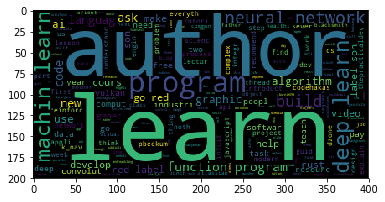

In [109]:
print(countem(c1)); plt.imshow(wc.generate(c1).to_array())

This first cluster pertains to "learning", "deep learning", "machine learning" and... "author"? This is a bias from the tweets of dev.to, which always include the keyword "author", and I know personally that I've liked many of their tweets. For example:

In [25]:
from IPython.core.display import display, HTML
display(HTML("<blockquote class=\"twitter-tweet\" data-lang=\"pt\"><p lang=\"en\" dir=\"ltr\">&quot;How do we achieve trust in such a system, or in a private blockchain? This is where the consensus comes in. The consensus assures that the participants will trust each other and the validity of the next block.&quot;<br>{ author: <a href=\"https://twitter.com/DamCosset?ref_src=twsrc%5Etfw\">@DamCosset</a> }<a href=\"https://t.co/oOeY5XCtyB\">https://t.co/oOeY5XCtyB</a></p>&mdash; The Practical Dev (@ThePracticalDev) <a href=\"https://twitter.com/ThePracticalDev/status/969211054399115266?ref_src=twsrc%5Etfw\">1 de março de 2018</a></blockquote><script async src=\"https://platform.twitter.com/widgets.js\" charset=\"utf-8\"></script>"
))

And there it is, the word "author".

### cluster 2

[('new', 38), ('make', 36), ('like', 36), ('want', 33), ('game', 31), ('think', 31), ('peopl', 30), ('work', 30), ('use', 26), ('ai', 25), ('know', 25), ('good', 24)]


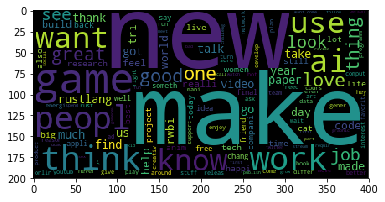

In [110]:
print(countem(c2, 12)); plt.imshow(wc.generate(c2).to_array())

Second cluster seems to be about making, game development, people, thinking... Mostly meta stuff.

### cluster 3

[('@sehurlburt', 45), ('open', 13), ('start', 12), ('write', 12), ('game', 9)]


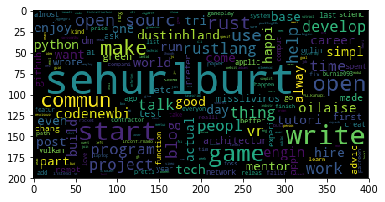

In [107]:
print(countem(c3)); plt.imshow(wc.generate(c3).to_array())

One user that I follow that usually posts very interesting and nuanced posts about business, living and coding is [@sehurlburt](twitter.com/sehurlburt). However, for her **username** to show up here, I must have liked replies to her tweets, which may have been her own (when you write short essays on twitter, one just replies to oneself to have enough space to do so). Otherwise, from looking at this wordcloud, this cluster seems mostly about coding.

## visualizing clusters - scatter plot

In order to make a nice 3D scatter plot, we must define some sort of values to plot the tweets along. You may have noticed in the `cluster_texts` function that the tf_idf values were stored. So let us take a look.

In [113]:
tf_idf.head()

(764, 2764)


,#,#acmsiggraph,#ad,#ahrc,#ai,#ampute,#anim,#apm,#ar,#arxiv,...,yssa,yuki,yum,zero,zombi,zoo,zuckerberg,zynga,zürich,ノ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is a very sparse (read "empty") matrix (2764 features!). This is because many tweets do not include the terms you see on the header of this table. I am even surprised to see "zoo" in there. Did I ever like a tweet with that term? Wow. Alright. Let's take a look at the sums.

In [8]:
top_tfidf = tf_idf.sum().sort_values(ascending=False)
top_tfidf[:10]

learn          13.581756
@sehurlburt    10.240749
make           10.112514
new             9.300349
game            9.292655
author          9.140174
want            8.843334
like            8.634657
peopl           8.167427
work            8.069575
dtype: float64

In [9]:
cutoff_point = round(top_tfidf['@rustlang'])
print(cutoff_point)
keep = top_tfidf[top_tfidf > cutoff_point].index.values # list of colnames

4.0


In [13]:
keep.shape[0]

56

So we went from 2764 dimensions down to 56. Not bad! (And we could reuse this reduced dimensionality to try and cluster again...).

We're now ready to keep the relevant terms now. Additionally, we are merging with the original data.

In [10]:
relevant_data = tf_idf[keep]
print(relevant_data.shape)
print(type(relevant_data))

(764, 56)
<class 'pandas.core.sparse.frame.SparseDataFrame'>


In [11]:
#pd.concat([df, relevant_data], axis=1)
df = df.reset_index().join(relevant_data.to_dense())  # you would not imagine how long this took me
df.set_index('date_time', drop=True, inplace=True)

In [12]:
with open('idf_tweets.df', 'wb') as handle:
    pickle.dump(df, handle)

In [14]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [15]:
top1 = [i[0] for i in countem(c1, 20)]
top2 = [i[0] for i in countem(c2, 20)]
top3 = [i[0] for i in countem(c3, 20)]

In [16]:
# define axis to plot along
axis_rust = df['@rustlang']
axis_a = df[top1[:9]].sum(axis=1)
axis_b = df[top2[:6]].sum(axis=1)
axis_c = df[top3[:3]].sum(axis=1)
# this is throwing index errors... top* does not have the right keywords to find in df
# thus I had to restrict these ranges... for now.

In [27]:
cluster1 = go.Scatter3d(
    x = axis_a[clusters[0]],
    y = axis_b[clusters[0]],
    z = axis_c[clusters[0]],
    mode = 'markers',
    marker = dict(
        size = 3,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [28]:
cluster2 = go.Scatter3d(
    x = axis_a[clusters[1]],
    y = axis_b[clusters[1]],
    z = axis_c[clusters[1]],
    mode = 'markers',
    marker = dict(
        size = 3,
        line=dict(
            color='rgba(160, 217, 117, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [26]:
cluster3 = go.Scatter3d(
    x = axis_a[clusters[2]],
    y = axis_b[clusters[2]],
    z = axis_c[clusters[2]],
    mode = 'markers',
    marker = dict(
        size = 3,
        line=dict(
            color='rgba(0, 198, 41, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

In [29]:
data = [cluster1, cluster2, cluster3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

This visualization is a work in progress.
- Many points are layed along an axis, meaning these tweets do not share anything in common with other tweets, at least with the `axis*` that I was _able_ to define.
- I could yet improve this clustering, but from the perspective of plotting, it's more of a matter of defining better axis, once I fix the index errors.
- I'd like to display the tweet instead of the xyz values when hovering over one of these points.
- also, this clustering was based on text alone. I could yet do some clustering based on the other variables I still have present, `screen_name` and `favorite_count`.